# **Transfer Learning with TensorFlow Part 2: Fine Tuning**

# **Importing Dependences**

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import zipfile
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Checking whether we are using GPU
!nvidia-smi

Sat Jul 31 07:03:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
#!wget https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/helper_functions.py
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 


--2021-07-31 07:03:29--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-31 07:03:29 (90.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import custom made reusable function
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

In [5]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [6]:
#!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

file_name = "/content/gdrive/MyDrive/dataset/10_food_classes_10_percent.zip"
unzip_data(file_name)

In [7]:
# Check out the data directory content
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent

In [8]:
# Create training and test directory paths
train_dir = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

# **Using image_dataset_from_directory() intead of ImageDataGenerator**

In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [10]:
train_data_10_percent = image_dataset_from_directory(train_dir,
                                                     label_mode="categorical",
                                                     batch_size = BATCH_SIZE,
                                                     image_size = IMG_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [11]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [12]:
# Check out class names of the training dataset
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [13]:
# See an example of a batch of data
for images, labels in train_data_10_percent.take(1):
  print(images, labels)

tf.Tensor(
[[[[2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   ...
   [6.17797012e+01 2.35130825e+01 2.84939880e+01]
   [6.57669601e+01 2.64098186e+01 3.24812469e+01]
   [7.06980591e+01 3.13409157e+01 3.74123421e+01]]

  [[2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   ...
   [6.60267334e+01 2.33893223e+01 2.96587009e+01]
   [6.36253014e+01 2.16967278e+01 2.39556122e+01]
   [6.51725311e+01 2.44461594e+01 2.53868160e+01]]

  [[2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   [2.50000000e+02 2.54000000e+02 2.53000000e+02]
   ...
   [9.35834503e+01 4.33915138e+01 5.23244705e+01]
   [8.93768768e+01 3.99483070e+01 4.35633545e+01]
   [8.65586624e+01 4.02101440e+01 3.86211281e+01]]

  ...

  [[1.16357208e+02 1.23572083e+01 1.97857361e+01]
   [1

# **Using TensorFlow Keras Application pre-trained model's weight for our application**

# **Model 0 :** Building a transfer learning model using the Keras Functional API

In [14]:
# 1. Create base model with tf.keras.application
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model
base_model.trainable = False

# 3. Create input layer into the model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. (Optional) normalization of inputs
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after Global Average Pooling2D: {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with output into a complete model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model and save the history
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=10,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data)), 
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])

16711680/16705208 [==============================] - 0s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after Global Average Pooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20210731-070407
Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 42s 309ms/step - loss: 1.9090 - accuracy: 0.4227 - val_loss: 1.3856 - val_accuracy: 0.7138
Epoch 2/10
24/24 [==============================] - 5s 193ms/step - loss: 1.1514 - accuracy: 0.7467 - val_loss: 0.9510 - val_accuracy: 0.7961
Epoch 3/10
24/24 [==============================] - 5s 193ms/step - loss: 0.8362 - accuracy: 0.8093 - val_loss: 0.8005 - val_accuracy: 0.8092
Epoch 4/10
24/24 [==============================] - 5s 194ms/step - loss: 0.6943 - accuracy: 0.8427 - val_loss: 0.7053 - val_accuracy: 0.8207
Epoch 5/10
24/24 [==============================] - 5s 193ms/step - loss: 0.5976 - accuracy: 0.8573 - val_loss: 0.6482 - val_accuracy: 0.8306
Epoch 6/10
24/24 [==============================] - 5s 203ms/step - loss: 0.5179 - accuracy: 0.8853 - val_loss: 0.5701 - val_accuracy: 0.8586
Epoch 7/10
24/24 [==============================] - 5s 206ms/step - loss: 0.4723 - accuracy: 0.8960 - val_loss: 0.5463 - val_accuracy: 0.8618
Epoch 8/10
24/24

In [15]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 112ms/step - loss: 0.4983 - accuracy: 0.8560


[0.498318612575531, 0.8560000061988831]

In [16]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_dwcon

In [17]:
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [18]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [19]:
results_10_percent = model_0.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4983 - accuracy: 0.8560


In [20]:
results_10_percent

[0.498318612575531, 0.8560000061988831]

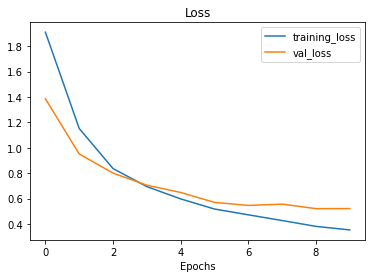

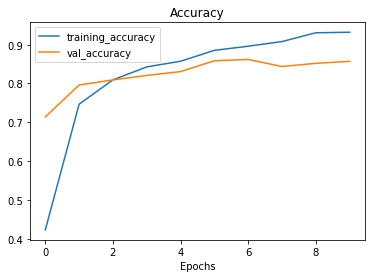

In [21]:
# Check out model_0's loss and accuracy curves
plot_loss_curves(history_10_percent)

# **Getting a feature vector from a trained model**

Demonstration of Global Average Pooling 2D layer

In [22]:
  # Define the input shape
  input_shape = (1, 4, 4, 3)

  # Create a random tensor
  tf.random.set_seed(42)
  input_tensor = tf.random.normal(input_shape)
  print(f"Random Input Tensor:\n {input_tensor}\n")

  # Pass the random tensor through a global average pooling 2D layer
  global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) 
  print(f"Tensor after global average pooling layer:\n {global_average_pooled_tensor}\n")

Random Input Tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

Tensor after global average pooling layer:
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [23]:
# Dig out what global average pooling layer doing
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

# **Running several experiments of transfer learning**

1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine tunning transfer learning with 10% of the training data with data augmentation
4. `model_4` - use fine tunning transfer learning on 100% of the traning data with data augmentation

# **Model 1: Feature extraction transfer learning on 1% of the data with augmentation**

## **Pre-Work**

In [24]:
# import and unzip the 10_food_classes_1% data

file_name = "/content/gdrive/MyDrive/dataset/10_food_classes_1_percent.zip"
unzip_data(file_name)

In [25]:
# Create training and testing directory

train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir = "10_food_classes_1_percent/test"

walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There a

In [26]:
IMG_SIZE = (224, 224) 
BATCH_SIZE = 32

train_data_1_percent = image_dataset_from_directory(train_dir_1_percent, 
                                                    label_mode="categorical", 
                                                    image_size=IMG_SIZE, 
                                                    batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir, 
                                         label_mode="categorical", 
                                         image_size=IMG_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


## **Adding data augmentation right into the model**

Using the `tf.keras,layers.experimental.preprocessing` module and creating a dedicated data sugmentation layer

In [27]:
print(tf.__version__)

2.5.0


This a relatively new feature added to TensorFlow 2.2+ but it's very powerful. Adding a data augmentation layer to the model has the following benefits:

Preprocessing of the images (augmenting them) happens on the GPU rather than on the CPU (much faster).
Images are best preprocessed on the GPU where as text and structured data are more suited to be preprocessed on the CPU.
Image data augmentation only happens during training so we can still export our whole model and use it elsewhere. And if someone else wanted to train the same model as us, including the same kind of data augmentation, they could.

In [28]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms

# Using Keras sequential API to build an augmentation layer 

data_augmentation = tf.keras.Sequential([
                    preprocessing.RandomFlip("horizontal"),
                    preprocessing.RandomRotation(0.2),
                    preprocessing.RandomZoom(0.2),
                    preprocessing.RandomHeight(0.2),
                    preprocessing.RandomWidth(0.2)
], name = "data_augmentation")

## **Visualization of data augmentation layer**

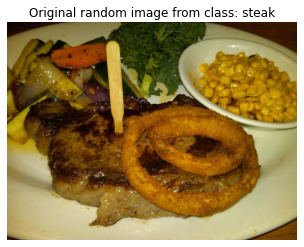

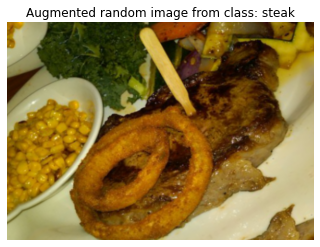

In [29]:
# View a random image
target_class = random.choice(train_data_1_percent.class_names) # choose a random class
target_dir = "10_food_classes_1_percent/train/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

# Augment the image
augmented_img = data_augmentation(tf.expand_dims(img, axis=0)) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## **Feature extraction transfer learning Model building**

In [30]:
# Creation of model_1

# 1. Initialize input shape 
input_shape = (224, 224, 3)

# 2.Initialize the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 3. Freezing the base model (non-trainable in model 1)
base_model.trainable = False

# 4. Create input layer into the model
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

# 5. Add in data augmentation layer created above
x = data_augmentation(inputs)

# 6. Pass augmented inputs to the base model
x = base_model(x, training=False)

# 7. Pass the outputs features from base model to pooling layer to get a feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 8. Add the dense output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# 9. Create the complete model 1
model_1 = tf.keras.Model(inputs, outputs)


In [31]:
# Compilation of model_1
model_1.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [32]:
# Fitting of model_1 with 1% training data
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback("transfer_learning", "1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20210731-070609


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/5
3/3 [==============================] - 11s 3s/step - loss: 2.4286 - accuracy: 0.0429 - val_loss: 2.2304 - val_accuracy: 0.1332
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.1679 - accuracy: 0.1429 - val_loss: 2.1261 - val_accuracy: 0.2319
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0111 - accuracy: 0.3143 - val_loss: 2.0289 - val_accuracy: 0.3273
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8044 - accuracy: 0.5714 - val_loss: 1.9157 - val_accuracy: 0.4342
Epoch 5/5
3/3 [==============================] - 3s 2s/step - loss: 1.6557 - accuracy: 0.6000 - val_loss: 1.8444 - val_accuracy: 0.4309


In [33]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [34]:
# Evaluate model_1 with test_data
results_1_percent_data_aug = model_1.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 1.8429 - accuracy: 0.4292


In [35]:
results_1_percent_data_aug

[1.8428915739059448, 0.4291999936103821]

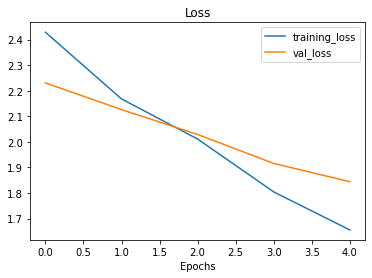

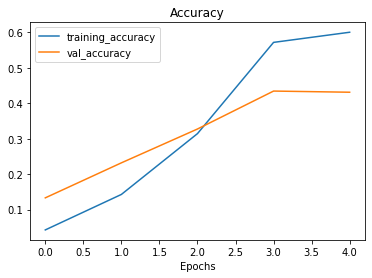

In [36]:
plot_loss_curves(history_1_percent)

# **Model 2: Feature extraction transfer learning with 10% of data with data augmentation**

In [37]:
# Create training and test directory paths
train_dir_10_percent = "10_food_classes_10_percent/train"
test_dir = "10_food_classes_10_percent/test"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = image_dataset_from_directory(train_dir_10_percent,
                                                     label_mode = "categorical",
                                                     image_size = IMG_SIZE,
                                                     batch_size = BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [41]:
# Create data_augmentation sequential layer
data_augmentation = tf.keras.Sequential([preprocessing.RandomFlip("horizontal"),
                                         preprocessing.RandomHeight(0.2),
                                         preprocessing.RandomWidth(0.2),
                                         preprocessing.RandomZoom(0.2),
                                         preprocessing.RandomRotation(0.2)                                         
], name = "data-augmentation")

In [43]:
#data_augmentation.summary()

In [44]:
# Creation of model_2

# 1. Initialize input shape 
input_shape = (224, 224, 3)

# 2.Initialize the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 3. Freezing the base model (non-trainable in model 2)
base_model.trainable=False

# 4. Create input layer into the model
inputs = layers.Input(shape=input_shape, name="input_layer")

# 5. Add in data augmentation layer created above
x = data_augmentation(inputs)

# 6. Pass augmented inputs to the base model
x = base_model(x, training=False)

# 7. Pass the outputs features from base model to pooling layer to get a feature vector
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 8. Add the dense output layer
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# 9. Create the complete model 2
model_2 = tf.keras.Model(inputs, outputs)


In [45]:
model_2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="categorical_crossentropy",
                metrics=["accuracy"])

In [46]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data-augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


## **Introducing `ModelCheckPoint` callback**

In [47]:
# Setup checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt" # note: remember saving directly to Colab is temporary

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True, # set to False to save the entire model
                                                         save_best_only=False, # set to True to save only the best model instead of a model every epoch 
                                                         save_freq="epoch", # save every epoch
                                                         verbose=1)

## **Fit Model 2 and including the ModelCheckPoint Callback**

In [48]:
initial_epochs = 5
history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_data_aug"),
                                                     checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20210731-070746
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 19s 598ms/step - loss: 2.0084 - accuracy: 0.3067 - val_loss: 1.4687 - val_accuracy: 0.6562

Epoch 00001: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 2/5
24/24 [==============================] - 11s 429ms/step - loss: 1.3600 - accuracy: 0.6613 - val_loss: 1.0205 - val_accuracy: 0.7747

Epoch 00002: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 3/5
24/24 [==============================] - 10s 398ms/step - loss: 1.0551 - accuracy: 0.7400 - val_loss: 0.8357 - val_accuracy: 0.7944

Epoch 00003: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 4/5
24/24 [==============================] - 10s 389ms/step - loss: 0.8973 - accuracy: 0.7840 - val_loss: 0.7071 - val_accuracy: 0.8289

Epoch 00004: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
Epoch 5/5
24/24 [==============================] - 9s 349ms/step - loss: 0.7838 - accuracy: 0.8120 - val_l

In [49]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4983 - accuracy: 0.8560


[0.49831870198249817, 0.8560000061988831]

In [50]:
result_10_percent_data_aug = model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.6906 - accuracy: 0.8140


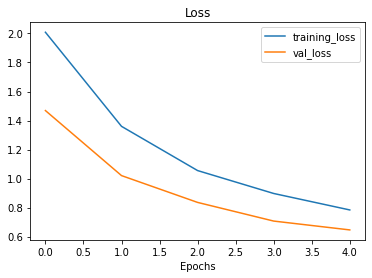

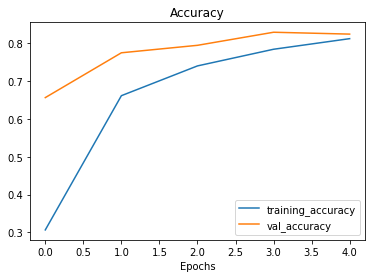

In [51]:
plot_loss_curves(history_10_percent_data_aug)

## **Loading in checkpointed weights**
Loading in checkpointed weights returns a model to a specific checkpoint

In [52]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [53]:
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 9s 103ms/step - loss: 0.6906 - accuracy: 0.8140


In [54]:
result_10_percent_data_aug

[0.6905521750450134, 0.8140000104904175]

In [55]:
loaded_weights_model_results

[0.6905522346496582, 0.8140000104904175]

# **Model 3: Fine tuning an existing model with 10% of the data**
**Note:** Fine-tunning ususally works best after training a feature extractor model for a few epochs and with huge amounts of data. 

## **Unfreeze some layers in the base_model so that they could be trained**

In [56]:
# Check the layers in model 2 with loaded weights

model_2.layers

In [58]:
# Verify which layer in model 2 is trainable

for layer in model_2.layers:
  print(layer.trainable)

True
True
False
True
True


In [59]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data-augmentation (Sequentia (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


In [64]:
# How many layers are trainable in model 2's base model
len(model_2.layers[2].trainable_variables)

0

In [65]:
len(base_model.trainable_variables)

0

In [66]:
# Check individual layer to see whether it is trainable

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [67]:
# As an example, first unfreeze the last 10 layers (i.e. setting last 10 layers.trainable = True)

base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False

In [69]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [70]:
# Re-compile model 2
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [71]:
len(model_2.trainable_variables)

12

## **Fine tunning the revised model 2 (i.e. Model 3)**

We're going to continue training on from where our previous model finished. Since it trained for 5 epochs, our fine-tuning will begin on the epoch 5 and continue for another 5 epochs.

To do this, we can use the initial_epoch parameter of the fit() method. We'll pass it the last epoch of the previous model's training history (history_10_percent_data_aug.epoch[-1]).

In [73]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# ReFit the model 
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs = fine_tune_epochs,
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1],
                                               callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_fine_tune_last_10")])



Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20210731-075612
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 20s 558ms/step - loss: 0.6848 - accuracy: 0.8187 - val_loss: 0.5248 - val_accuracy: 0.8438
Epoch 6/10
24/24 [==============================] - 10s 387ms/step - loss: 0.5689 - accuracy: 0.8280 - val_loss: 0.5297 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 9s 381ms/step - loss: 0.5036 - accuracy: 0.8640 - val_loss: 0.4759 - val_accuracy: 0.8372
Epoch 8/10
24/24 [==============================] - 9s 347ms/step - loss: 0.4303 - accuracy: 0.8680 - val_loss: 0.4624 - val_accuracy: 0.8487
Epoch 9/10
24/24 [==============================] - 8s 332ms/step - loss: 0.4220 - accuracy: 0.8787 - val_loss: 0.5042 - val_accuracy: 0.8388
Epoch 10/10
24/24 [==============================] - 9s 366ms/step - loss: 0.3837 - accuracy: 0.8800 - val_loss: 0.4664 - val_accuracy: 0.8553


In [74]:
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.4772 - accuracy: 0.8428


In [75]:
result_10_percent_data_aug

[0.6905521750450134, 0.8140000104904175]

## **Create a function to compare one series of running `fit()` with another(e.g. before and after fine tunning)**

In [85]:
def compare_history(original_history, new_history, initial_epochs=5):
  """
  Compares two model history objects.
  """

  # Get origina history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original and new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # Create the plot for accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Validation Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # Create the plot for loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Validation Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine Tuning")
  plt.legend(loc="Upper right")
  plt.title("Training and Validation Loss")
  plt.xlabel("epoch")
  plt.show()





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Unrecognized location 'Upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


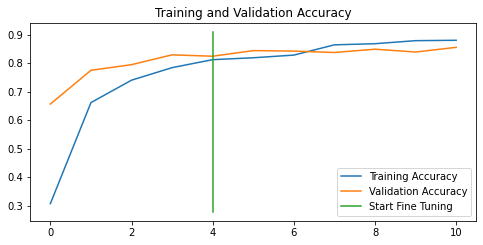

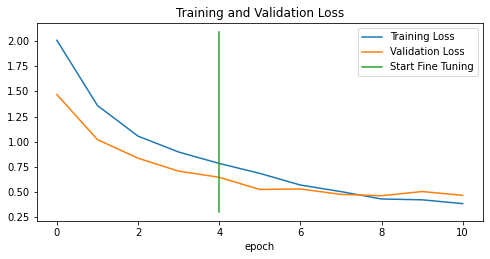

In [86]:
compare_history(history_10_percent_data_aug, history_fine_10_percent_data_aug, initial_epochs=5)

# **Model 4: Fine-tunning and existing model on all of the Food101 dataset**

## **Pre Work**

In [89]:
file_name = "/content/gdrive/MyDrive/dataset/10_food_classes_all_data.zip"
unzip_data(file_name)

In [90]:
train_dir_all = "10_food_classes_all_data/train"
test_dir = "10_food_classes_all_data/test"

walk_through_dir("10_food_classes_all_data")

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/train'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ice_cream'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_curry'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/ramen'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/hamburger'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/grilled_salmon'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/chicken_wings'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/sushi'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/fried_rice'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/steak'.
There are 0 directories and 750 images in '10_food_classes_all_data/train/pizza'.

In [92]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_data_all = image_dataset_from_directory(train_dir_all,
                                              label_mode="categorical",
                                              image_size=IMG_SIZE,
                                              batch_size=BATCH_SIZE)

test_data = image_dataset_from_directory(test_dir,
                                         label_mode="categorical",
                                         image_size=IMG_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [93]:
model_2.evaluate(test_data)

79/79 [==============================] - 9s 105ms/step - loss: 0.4772 - accuracy: 0.8428


[0.4772128760814667, 0.8428000211715698]

In [94]:
results_fine_tune_10_percent

[0.4772130250930786, 0.8428000211715698]

## **Revert the fine-tunned model 2(i.e. model 3) back to its feature extraction weights**

In [95]:
# Load model from checkpoint, that way we can fine-tune from the same stage the 10 percent data model was fine-tuned from
# revert model back to saved weights
model_2.load_weights(checkpoint_path) 

In [96]:
# Check whether Model 2 is reverted
model_2.evaluate(test_data)

79/79 [==============================] - 9s 104ms/step - loss: 0.6906 - accuracy: 0.8140


[0.6905521750450134, 0.8140000104904175]

In [97]:
# Verify with the model 2 history
result_10_percent_data_aug

[0.6905521750450134, 0.8140000104904175]

the previous steps might seem quite confusing but all we've done is:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data (with all base model layers frozen) and saved the model's weights using ModelCheckpoint (Model 2).
2. Fine-tuned the same model on the same 10% of the data for a further 5 epochs with the top 10 layers of the base model unfrozen (Model 3).
3. Saved the results and training logs each time.
4. Reloaded the model from 1 to do the same steps as 2 but with all of the data (Model 4).

In [98]:
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data-augmentation True
2 efficientnetb0 True
3 global_average_pooling_layer True
4 output_layer True


In [99]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

##  **Recompile the model**

In [100]:
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

## **Traing the model with all train data and incorporate fine tunning technique**

In [103]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# ReFit the model with 100% of all the data
history_fine_10_classes_full_data_aug = model_2.fit(
    train_data_all,
    epochs = fine_tune_epochs,
    validation_data=test_data,
    validation_steps=int(0.25*len(test_data)),
    initial_epoch=history_10_percent_data_aug.epoch[-1],
    callbacks=[create_tensorboard_callback("transfer_learning", 
                                           "full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20210731-090132
Epoch 5/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


235/235 [==============================] - 48s 203ms/step - loss: 0.7186 - accuracy: 0.7683 - val_loss: 0.3924 - val_accuracy: 0.8882
Epoch 6/10
235/235 [==============================] - 60s 251ms/step - loss: 0.6007 - accuracy: 0.8080 - val_loss: 0.3343 - val_accuracy: 0.9030
Epoch 7/10
235/235 [==============================] - 52s 221ms/step - loss: 0.5260 - accuracy: 0.8295 - val_loss: 0.3158 - val_accuracy: 0.9062
Epoch 8/10
235/235 [==============================] - 52s 220ms/step - loss: 0.4775 - accuracy: 0.8501 - val_loss: 0.3558 - val_accuracy: 0.8898
Epoch 9/10
235/235 [==============================] - 49s 207ms/step - loss: 0.4476 - accuracy: 0.8571 - val_loss: 0.3093 - val_accuracy: 0.9062
Epoch 10/10
235/235 [==============================] - 46s 196ms/step - loss: 0.4222 - accuracy: 0.8643 - val_loss: 0.2907 - val_accuracy: 0.9194


In [104]:
results_fine_tune_full_data = model_2.evaluate(test_data)
results_fine_tune_full_data

79/79 [==============================] - 9s 105ms/step - loss: 0.3388 - accuracy: 0.8932


[0.33880865573883057, 0.8931999802589417]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Unrecognized location 'Upper right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


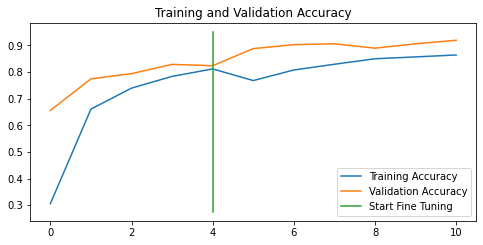

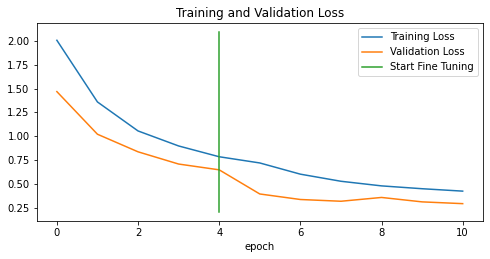

In [105]:
compare_history(history_10_percent_data_aug,
                history_fine_10_classes_full_data_aug,
                initial_epochs=5)

# **Viewing all experimnet data on TensorBoard**

In [107]:
# View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# Upload TensorBoard dev records

!tensorboard dev upload --logdir ./transfer_learning \
  --name "Transfer learning experiments" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning" \
  --one_shot # exits the uploader when upload has finished

2021-07-31 09:17:14.979665: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./transfer_learning

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=373649185512-8v619h5kft38l4456nm2dj4ubeqsrvh6.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3

The TensorBoard link is:
https://tensorboard.dev/experiment/j0T9hnCrTvac7ezSz6enjA/

In [108]:
# View previous experiments
!tensorboard dev list

2021-07-31 09:24:47.448973: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/j0T9hnCrTvac7ezSz6enjA/
	Name                 Transfer learning experiments
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   j0T9hnCrTvac7ezSz6enjA
	Created              2021-07-31 09:17:47 (7 minutes ago)
	Updated              2021-07-31 09:17:53 (7 minutes ago)
	Runs                 11
	Tags                 5
	Scalars              192
	Tensor bytes         0
	Binary object bytes  5085542
Total: 1 experiment(s)
